# Annotated Corpus for Named Entity Recognition

The processed dataset *NER* in this notebook, is available on *Kaggle*.[link](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus?select=ner.csv)



## 1. Import the Libraries 

In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter
import tensorflow as tf
from ast import literal_eval
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, RNN, GRUCell, Conv2D, Embedding, Bidirectional, Dropout
import matplotlib.pyplot as plt

## 2. Upload and explore the Data

In [2]:
df = pd.read_csv(r"E:\Jihane 2022\Exams\exam 157\ner_dataset.csv",encoding= 'unicode_escape')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


**Examination of each column :**
- Sentence # : Contains sentence number in the text.
- Word : Lists the words in each sentence.
- POS : Refers to the gramatical group each word belongs to.
- Tag : Identifies the word's name entity 

In [3]:
sentence = df["Sentence #"].value_counts().index[-1]
nbr_sentence = sentence.split()
print("The text contains",nbr_sentence[-1], "sentences")
print("There is",df.isnull().sum().sum(), "missing values")

The text contains 47959 sentences
There is 1000616 missing values


In [4]:
tags = list(set(df.Tag))
tags

['I-per',
 'I-tim',
 'B-nat',
 'B-org',
 'I-art',
 'B-eve',
 'B-per',
 'B-gpe',
 'B-tim',
 'I-org',
 'B-geo',
 'I-nat',
 'B-art',
 'I-eve',
 'O',
 'I-geo',
 'I-gpe']

**B** denotes the **B**eginning of an entity, **I** stands for "inside" and is used for all words comprising the entity except the first one, and **O** means the absence of entity.
The acronyms refers to : 
une liste:
- geo : Administrative geographic area
- per : Person
- org : Organization
- gpe : Geopolitical entity
- tim : Time
- art : Work of art
- eve : Name of events
- nat : Natural hazards


## 2. Definition of required functions 


In [5]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()


In [6]:
# Sentence construction function
def liste_phrase(liste):
    phrase = ' '.join(liste)
    return phrase

In [7]:
# Tokenization function
def target_tokenize(target, tag2indx):
    target_prep = []
    for t in target :
        target_tokenized = []
        for tag in t :
            target_tokenized.append(tag2idx[tag])
        target_prep.append(target_tokenized)
    return target_prep

## 3. Data pre-processing
### 3.1. Missing values

In [8]:
# Remove missing values :
df = df.fillna(method='ffill')


In [9]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [10]:
df.shape

(1048575, 4)

**Remarque** : Since the dataset is enormus, only the half will be used.

In [11]:
df_half = np.array_split(df, 2)[0]
df_half.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


### 3.2. Stop-words

In [12]:
# language choice
stop_words = stopwords.words('english')

df_half.Word = df_half.Word.swifter.apply(lambda x :preprocess_sentence(x))
df_half.head()

Pandas Apply:   0%|          | 0/524288 [00:00<?, ?it/s]

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,,VBP,O
4,Sentence: 1,marched,VBN,O


**NB** : the stop words found were replaced with ' ' (space). so the next step is to delete those rows from the dataframe.

In [13]:
df_half = df_half[df_half["Word"] != '']

In [14]:
df_half.shape

(315611, 4)

**NB** : This step cuts down 40% of the dataframe.

### 3.3. Sentence construction: Putting words together

In [15]:
df_half = df_half.drop(['POS'], axis = 1)
df_half = df_half.groupby('Sentence #').agg(list)
df_half = df_half.reset_index(drop = True)
df_half.head()

,Word,Tag
0,"[thousands, demonstrators, marched, london, pr...","[O, O, O, B-geo, O, O, B-geo, O, O, B-gpe, O, ..."
1,"[iranian, officials, say, expect, get, access,...","[B-gpe, O, O, O, O, O, O, O, O, O, B-tim, B-or..."
2,"[helicopter, gunships, saturday, pounded, mili...","[O, O, B-tim, O, O, O, B-geo, O, O, O, B-org, ..."
3,"[left, tense, hour long, standoff, riot, polic...","[O, O, O, O, O, O, O]"
4,"[. ., relief, coordinator, jan, egeland, said,...","[B-geo, O, O, B-per, I-per, O, B-tim, B-geo, B..."


In [16]:
df_half.shape

(23977, 2)

In [17]:
# Transformation of the list of words to a sentence :
sentences = []
for i in df_half.Word.to_list():
    sentences.append(liste_phrase(i))
    
df_half["sentence"] = sentences

df_half = df_half.drop(["Word"], axis = 1)
df_half.head()

,Tag,sentence
0,"[O, O, O, B-geo, O, O, B-geo, O, O, B-gpe, O, ...",thousands demonstrators marched london protest...
1,"[B-gpe, O, O, O, O, O, O, O, O, O, B-tim, B-or...",iranian officials say expect get access sealed...
2,"[O, O, B-tim, O, O, O, B-geo, O, O, O, B-org, ...",helicopter gunships saturday pounded militant ...
3,"[O, O, O, O, O, O, O]",left tense hour long standoff riot police .
4,"[B-geo, O, O, B-per, I-per, O, B-tim, B-geo, B...",. . relief coordinator jan egeland said sunday...


In [18]:
# transformation of the type of the colunm df[Tags]

Tags = []
for i in df_half.Tag.to_list():
    Tags.append(str(i))
    
df_half["Tags"] = Tags
df_half = df_half.drop(["Tag"], axis = 1)
df_half.head()

,sentence,Tags
0,thousands demonstrators marched london protest...,"['O', 'O', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O..."
1,iranian officials say expect get access sealed...,"['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."
2,helicopter gunships saturday pounded militant ...,"['O', 'O', 'B-tim', 'O', 'O', 'O', 'B-geo', 'O..."
3,left tense hour long standoff riot police .,"['O', 'O', 'O', 'O', 'O', 'O', 'O']"
4,. . relief coordinator jan egeland said sunday...,"['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-..."


### 3.4. Tokenization

In [19]:
feature = df_half.sentence
target = df_half.Tags

In [20]:
tokenizer_ft = tf.keras.preprocessing.text.Tokenizer(num_words = 240000)
tokenizer_ft.fit_on_texts(feature)

In [21]:
# The dictionnary word : id 
word2idx = tokenizer_ft.word_index
word2idx

{'said': 1,
 'says': 2,
 'say': 3,
 'president': 4,
 'officials': 5,
 'government': 6,
 'two': 7,
 'killed': 8,
 'people': 9,
 'also': 10,
 'year': 11,
 'new': 12,
 'military': 13,
 'united': 14,
 'country': 15,
 'police': 16,
 'last': 17,
 'one': 18,
 'minister': 19,
 'iraq': 20,
 'security': 21,
 'states': 22,
 'least': 23,
 'group': 24,
 'state': 25,
 'three': 26,
 'world': 27,
 'tuesday': 28,
 'since': 29,
 'forces': 30,
 'week': 31,
 'wednesday': 32,
 'thursday': 33,
 'monday': 34,
 'friday': 35,
 'oil': 36,
 'would': 37,
 'foreign': 38,
 'iran': 39,
 'troops': 40,
 'iraqi': 41,
 'saturday': 42,
 'city': 43,
 'sunday': 44,
 'first': 45,
 'month': 46,
 'nuclear': 47,
 'prime': 48,
 'authorities': 49,
 'international': 50,
 'afghanistan': 51,
 'palestinian': 52,
 'militants': 53,
 'israeli': 54,
 'nations': 55,
 'attacks': 56,
 'former': 57,
 'israel': 58,
 'war': 59,
 'called': 60,
 'talks': 61,
 'attack': 62,
 'south': 63,
 'china': 64,
 'million': 65,
 'years': 66,
 'near': 67,
 

In [22]:
# The dictionnary id : word 
idx2word = tokenizer_ft.index_word
idx2word

{1: 'said',
 2: 'says',
 3: 'say',
 4: 'president',
 5: 'officials',
 6: 'government',
 7: 'two',
 8: 'killed',
 9: 'people',
 10: 'also',
 11: 'year',
 12: 'new',
 13: 'military',
 14: 'united',
 15: 'country',
 16: 'police',
 17: 'last',
 18: 'one',
 19: 'minister',
 20: 'iraq',
 21: 'security',
 22: 'states',
 23: 'least',
 24: 'group',
 25: 'state',
 26: 'three',
 27: 'world',
 28: 'tuesday',
 29: 'since',
 30: 'forces',
 31: 'week',
 32: 'wednesday',
 33: 'thursday',
 34: 'monday',
 35: 'friday',
 36: 'oil',
 37: 'would',
 38: 'foreign',
 39: 'iran',
 40: 'troops',
 41: 'iraqi',
 42: 'saturday',
 43: 'city',
 44: 'sunday',
 45: 'first',
 46: 'month',
 47: 'nuclear',
 48: 'prime',
 49: 'authorities',
 50: 'international',
 51: 'afghanistan',
 52: 'palestinian',
 53: 'militants',
 54: 'israeli',
 55: 'nations',
 56: 'attacks',
 57: 'former',
 58: 'israel',
 59: 'war',
 60: 'called',
 61: 'talks',
 62: 'attack',
 63: 'south',
 64: 'china',
 65: 'million',
 66: 'years',
 67: 'near',
 

In [23]:
# Trying the tokenizer to do a little check that the ids aren't wrong :
feature_prep = tokenizer_ft.texts_to_sequences(feature)

In [24]:
feature[1]

'iranian officials say expect get access sealed sensitive parts plant wednesday iaea surveillance system begins functioning .'

In [25]:
feature_prep[1]

[252,
 5,
 3,
 1631,
 660,
 892,
 3601,
 3422,
 732,
 807,
 32,
 1393,
 1919,
 302,
 1920,
 4423]

In [26]:
# Checking the lenght of the sentences :
maxlen = []
for i in range(len(df_half.sentence)):
    maxlen.append(len(df_half.sentence[i].split()))
    
print(f"The longest sentence contains {max(maxlen)} words.")
print(f"The shortest sentence contains {min(maxlen)} word.")

The longest sentence contains 45 words.
The shortest sentence contains 1 word.


In [27]:
# A padding is required at this point :
feature_padded = tf.keras.preprocessing.sequence.pad_sequences(feature_prep, maxlen = max(maxlen), padding = 'post', truncating = 'post')
feature_padded[1]

array([ 252,    5,    3, 1631,  660,  892, 3601, 3422,  732,  807,   32,
       1393, 1919,  302, 1920, 4423,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [28]:
# Target tokenization :
indx2tag = { i : tags[i] for i in range(0, len(tags) ) }
indx2tag
    

{0: 'I-per',
 1: 'I-tim',
 2: 'B-nat',
 3: 'B-org',
 4: 'I-art',
 5: 'B-eve',
 6: 'B-per',
 7: 'B-gpe',
 8: 'B-tim',
 9: 'I-org',
 10: 'B-geo',
 11: 'I-nat',
 12: 'B-art',
 13: 'I-eve',
 14: 'O',
 15: 'I-geo',
 16: 'I-gpe'}

In [29]:
tag2idx = {v: k for k, v in indx2tag.items()}
tag2idx

{'I-per': 0,
 'I-tim': 1,
 'B-nat': 2,
 'B-org': 3,
 'I-art': 4,
 'B-eve': 5,
 'B-per': 6,
 'B-gpe': 7,
 'B-tim': 8,
 'I-org': 9,
 'B-geo': 10,
 'I-nat': 11,
 'B-art': 12,
 'I-eve': 13,
 'O': 14,
 'I-geo': 15,
 'I-gpe': 16}

In [30]:
num_tags = len(tags)
num_tags

17

In [31]:
# Trying the tag tokenizer to do a little check that the ids aren't wrong :
target[1]

"['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'B-org', 'O', 'O', 'O', 'O', 'O']"

In [32]:
target_ready = []

for sen_tags in target:
    target_ready.append(literal_eval(sen_tags))
    
target_ready[1]

['B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-tim',
 'B-org',
 'O',
 'O',
 'O',
 'O',
 'O']

In [33]:
target_prep = target_tokenize(target_ready, tag2idx)
target_prep[1]

[7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 3, 14, 14, 14, 14, 14]

In [34]:
target_padded = tf.keras.preprocessing.sequence.pad_sequences(target_prep, maxlen = max(maxlen), padding = 'post', truncating = 'post')
target_padded[1]
# We need to have the same lenght as the fetures.

array([ 7, 14, 14, 14, 14, 14, 14, 14, 14, 14,  8,  3, 14, 14, 14, 14, 14,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

## 3.Model training

### 3.1. Data split

In [35]:

X_train, X_test, y_train, y_test = train_test_split(feature_padded, target_padded, test_size = 0.2, random_state = 1234)

### 3.2. Knn Model definition

In [36]:
voc_size_inp_word = len(tokenizer_ft.word_counts)+1
voc_size_inp_tag = num_tags+1

In [37]:
model = Sequential()
model.add(Embedding(voc_size_inp_word, 128))
model.add(Bidirectional(RNN(GRUCell(128, recurrent_initializer='glorot_uniform'),return_sequences=True)))
model.add(Dropout(0.3))
model.add(Dense(voc_size_inp_tag, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2532352   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        198144    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 dense (Dense)               (None, None, 18)          4626      
                                                                 
Total params: 2,735,122
Trainable params: 2,735,122
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_data = [X_test, y_test])

Epoch 1/5
300/300 [==============================] - 40s 124ms/step - loss: 0.3803 - accuracy: 0.9082 - val_loss: 0.1949 - val_accuracy: 0.9467
Epoch 2/5
300/300 [==============================] - 35s 118ms/step - loss: 0.1721 - accuracy: 0.9505 - val_loss: 0.1582 - val_accuracy: 0.9538
Epoch 3/5
300/300 [==============================] - 36s 120ms/step - loss: 0.1394 - accuracy: 0.9579 - val_loss: 0.1492 - val_accuracy: 0.9563
Epoch 4/5
300/300 [==============================] - 36s 121ms/step - loss: 0.1212 - accuracy: 0.9623 - val_loss: 0.1479 - val_accuracy: 0.9566
Epoch 5/5
300/300 [==============================] - 36s 121ms/step - loss: 0.1066 - accuracy: 0.9659 - val_loss: 0.1482 - val_accuracy: 0.9572


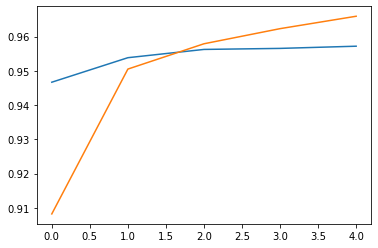

In [40]:


plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"]);

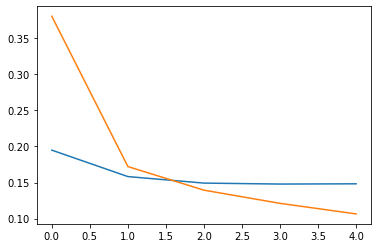

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"]);

In [44]:
test = model.evaluate(X_test, y_test, batch_size = 128)
print("test loss and test accuracy" , test)

38/38 [==============================] - 2s 50ms/step - loss: 0.1482 - accuracy: 0.9572
test loss and test accuracy [0.14824336767196655, 0.9571958184242249]


In [45]:
y_prob = model.predict(X_test[:768], batch_size = 64)
y_pred_tok = y_prob.argmax(axis = -1)
y_true_tok = y_test[:768]

def predict(n):
    word = []
    true_tag = []
    predicted_tag = []
    for i in range(34):
        if X_test[n,i] == 0:
            break
        else: 
            word.append(idx2word[X_test[n,i]])
            true_tag.append(indx2tag[y_true_tok[n,i]])
            predicted_tag.append(indx2tag[y_pred_tok[n,i]])
    data = pd.DataFrame({ "word " : word, "true_tag" : true_tag, "predicted_tag" : predicted_tag})
    return(data)

In [50]:
predict(4)

,word,true_tag,predicted_tag
0,colombian,B-gpe,B-gpe
1,marxist,O,O
2,rebels,O,O
3,kidnapped,O,O
4,february,B-tim,B-tim
5,campaigned,O,O
